<a href="https://colab.research.google.com/github/Macarena6MiMa/ProyectoML/blob/main/ProyectoFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

0. Cargar datos

In [152]:
# 1. Instalar gdown (si no está instalado)
!pip install -q gdown

# 2. Descargar el ZIP desde Google Drive (usando gdown)
!gdown --id 1rBZQjj55ea7RxD0KN5v855FW3OFf-BAZ --output training2017.zip

# 3. Descomprimir el contenido en /content/training2017
!unzip -q training2017.zip -d /content/training2017

# 4. Definir ruta de trabajo
data_dir = r'/content/training2017/training2017'

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1rBZQjj55ea7RxD0KN5v855FW3OFf-BAZ
From (redirected): https://drive.google.com/uc?id=1rBZQjj55ea7RxD0KN5v855FW3OFf-BAZ&confirm=t&uuid=3c264c5b-d42d-4233-a1e9-04713d56b4c0
To: /content/training2017.zip
100% 99.2M/99.2M [00:00<00:00, 240MB/s]
replace /content/training2017/training2017/A00001.hea? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


1. Cargar y visualizar señales ECG


DataFrame de Características (Registros Válidos):
  registro   fs  duracion_seq   media_mv     mstd_mv  skewness   kurtosis  \
0   A00001  300          30.0  18.569444  168.317981  2.381524  10.374763   
1   A00002  300          30.0  21.240556  176.650702  3.157843  17.775676   
2   A00003  300          60.0  -6.789167  149.176870 -1.649478   6.226098   
3   A00004  300          30.0  40.544444  213.619469  3.523494  14.134977   
4   A00005  300          60.0  20.819556  209.003226  2.241977   8.749932   

   rr_mean_s  rr_std_s clase  
0   0.420610  0.115794     N  
1   0.483607  0.125675     N  
2   0.384237  0.075847     N  
3   0.507684  0.139735     A  
4   0.441901  0.096019     A  


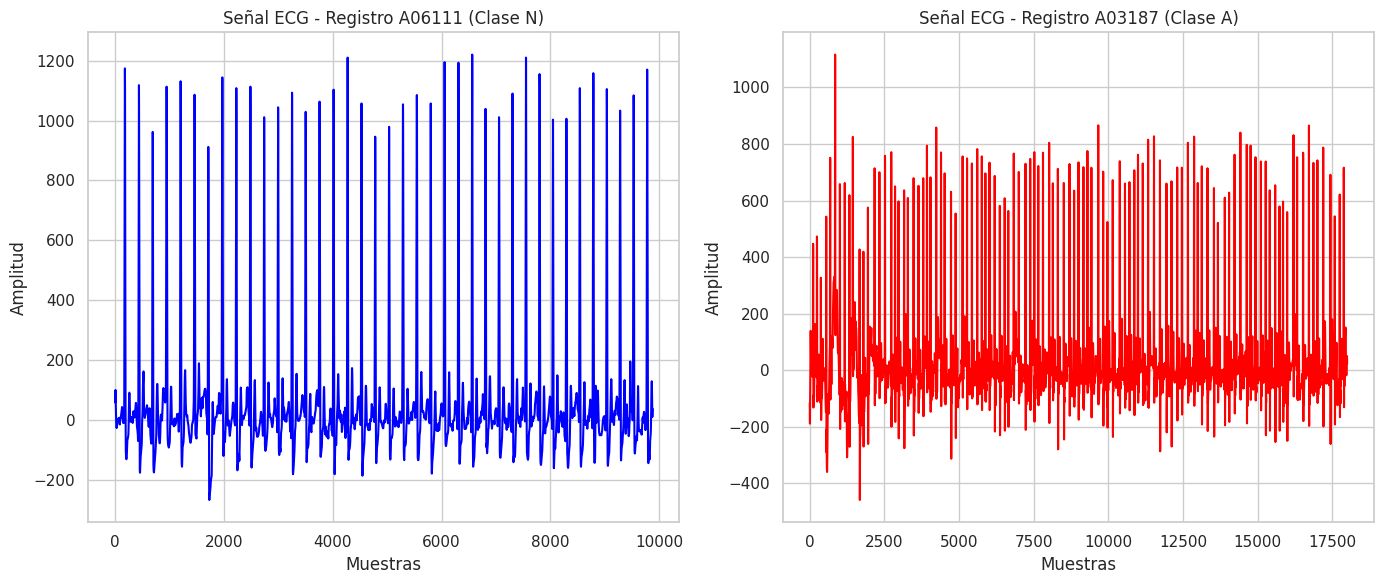

In [181]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks

valid_records_data = []
# Cargar archivo REFERENCE.csv
reference_path = os.path.join(data_dir, 'REFERENCE.csv')
df_labels = pd.read_csv(reference_path, header=None, names=['registro', 'clase'])

# Obtener la lista de archivos .mat y .hea
mat_files = sorted([f for f in os.listdir(data_dir) if f.endswith('.mat')])
hea_files = sorted([f for f in os.listdir(data_dir) if f.endswith('.hea')])

# Asegurarse de que haya la misma cantidad de archivos .mat y .hea
if len(mat_files) != len(hea_files):
    print("Advertencia: El número de archivos .mat y .hea no coincide.")

# Iterar sobre los archivos .mat
for mat_file in mat_files:
    registro = mat_file.replace('.mat', '')

    # Verificar que exista un archivo .hea correspondiente
    hea_file = registro + '.hea'
    if hea_file not in hea_files:
        print(f"Archivo .hea no encontrado para el registro: {registro}. Saltando.")
        continue

    hea_path = os.path.join(data_dir, hea_file)
    mat_path = os.path.join(data_dir, mat_file)

    # Verificar si existen ambos archivos (.mat y .hea)
    if not os.path.exists(mat_path) or not os.path.exists(hea_path):
        print(f"Archivos .mat o .hea faltantes para el registro: {registro}. Saltando.")
        continue

    try:
        # Cargar señal desde .mat
        mat_data = loadmat(mat_path)
        if 'val' not in mat_data:
            print(f"'val' key not found in {mat_file}. Saltando.")
            continue
        signal = mat_data['val'].flatten()

        # Cargar frecuencia de muestreo desde .hea
        with open(hea_path, 'r') as f:
            header_line = f.readline().split()
            if len(header_line) < 3:
                print(f"Formato de archivo .hea incorrecto para {registro}. Saltando.")
                continue
            fs_str = header_line[2]
            try:
                fs = int(fs_str)
            except ValueError:
                print(f"No se pudo parsear la frecuencia de muestreo para {registro}. Saltando.")
                continue

        # Calcular características
        duracion_seq = len(signal) / fs
        media_mv = np.mean(signal)
        mstd_mv = np.std(signal)
        sk = skew(signal)
        kurt = kurtosis(signal)

        # Cálculo de características de picos y variabilidad RR (requiere señal con picos)
        peaks, _ = find_peaks(signal, distance=fs*0.3)
        rr_intervals = np.diff(peaks) / fs if len(peaks) > 1 else [np.nan]
        rr_mean_s = np.mean(rr_intervals)
        rr_std_s = np.std(rr_intervals)

        # Buscar clase en REFERENCE.csv
        clase_row = df_labels[df_labels['registro'] == registro]
        clase = clase_row['clase'].values[0] if not clase_row.empty else 'Desconocida'

        # Almacenar datos en la lista
        valid_records_data.append({
            'registro': registro,
            'fs': fs,
            'duracion_seq': duracion_seq,
            'media_mv': media_mv,
            'mstd_mv': mstd_mv,
            'skewness': sk,
            'kurtosis': kurt,
            'rr_mean_s': rr_mean_s,
            'rr_std_s': rr_std_s,
            'clase': clase
        })

    except Exception as e:
        print(f"Error procesando el registro {registro}: {e}. Saltando.")
        continue

# Convertir la lista de diccionarios a un DataFrame de pandas
df_features = pd.DataFrame(valid_records_data)

# Mostrar las primeras filas del DataFrame de características
print("\nDataFrame de Características (Registros Válidos):")
print(df_features.head())

# 6. Seleccionar un registro aleatorio de clase N y A
df_n = df_features[df_features['clase'] == 'N']
df_a = df_features[df_features['clase'] == 'A']

if len(df_n) == 0 or len(df_a) == 0:
    print("No hay suficientes registros de clase N y A para graficar.")
else:
    registro_n = df_n.sample(n=1, random_state=35)['registro'].values[0]
    registro_a = df_a.sample(n=1, random_state=35)['registro'].values[0]

    # 7. Cargar señales
    signal_n = loadmat(os.path.join(data_dir, registro_n + '.mat'))['val'].flatten()
    signal_a = loadmat(os.path.join(data_dir, registro_a + '.mat'))['val'].flatten()

    # 8. Visualización
    plt.figure(figsize=(14, 6))

    # Señal N
    plt.subplot(1, 2, 1)
    plt.plot(signal_n, color='blue')
    plt.title(f'Señal ECG - Registro {registro_n} (Clase N)')
    plt.xlabel('Muestras')
    plt.ylabel('Amplitud')

    # Señal A
    plt.subplot(1, 2, 2)
    plt.plot(signal_a, color='red')
    plt.title(f'Señal ECG - Registro {registro_a} (Clase A)')
    plt.xlabel('Muestras')
    plt.ylabel('Amplitud')

    plt.tight_layout()
    plt.show()


2.Inspección básica del dataset

In [182]:
# Inspección básica del DataFrame de características
print("\nInspección básica del DataFrame de características:")
df_features.info()
print("\nValores nulos por columna antes de la limpieza:")
print(df_features.isnull().sum())

# Limpieza de datos:
# 1. Eliminar filas donde alguna característica sea NaN (esto ocurre principalmente con rr_mean_s y rr_std_s
#    si el registro tiene 0 o 1 pico detectado).
df_cleaned = df_features.dropna().copy()
df_cleaned.replace([np.inf, -np.inf], np.nan, inplace=True)
df_cleaned.dropna(inplace=True)


print(f"\nNúmero de registros después de eliminar filas con NaN/inf: {len(df_cleaned)}")
print("\nValores nulos por columna después de la limpieza:")
print(df_cleaned.isnull().sum())


# Guardar el DataFrame limpio como CSV
output_cleaned_csv_path = 'ecg_features_cleaned.csv'
df_cleaned.to_csv(output_cleaned_csv_path, index=False)
print(f"\nDataFrame limpio guardado en: {output_cleaned_csv_path}")


# Cargar el CSV limpio (si no está ya cargado en df_cleaned)
# df_cleaned = pd.read_csv('ecg_features_cleaned.csv') # Uncomment this line if running independently

# Separar por clase en el DataFrame limpio
df_n_cleaned = df_cleaned[df_cleaned['clase'] == 'N']
df_a_cleaned = df_cleaned[df_cleaned['clase'] == 'A']

# Seleccionar 738 registros de cada clase aleatoriamente del DataFrame limpio
n_samples = 738
if len(df_n_cleaned) < n_samples or len(df_a_cleaned) < n_samples:
    print(f"No hay suficientes registros limpios de clase N ({len(df_n_cleaned)}) o A ({len(df_a_cleaned)}) para seleccionar {n_samples} de cada uno.")
else:
    df_n_sample_cleaned = df_n_cleaned.sample(n=n_samples, random_state=42).reset_index(drop=True)
    df_a_sample_cleaned = df_a_cleaned.sample(n=n_samples, random_state=42).reset_index(drop=True)

    # Concatenar los DataFrames muestreados limpios
    df_sampled_cleaned = pd.concat([df_n_sample_cleaned, df_a_sample_cleaned], ignore_index=True)

    # Desordenar los registros
    df_selected_cleaned = df_sampled_cleaned.sample(frac=1, random_state=42).reset_index(drop=True)

    # Mostrar resumen estadístico del DataFrame limpio y seleccionado
    print("\nResumen estadístico de los 1400 registros limpios y seleccionados:")
    print(df_selected_cleaned.describe())

    # Opcional: Mostrar las primeras filas para verificar
    print("\nPrimeras 5 filas del DataFrame limpio, muestreado y desordenado:")
    print(df_selected_cleaned.head(20))

    # Opcional: Verificar el balance de clases en la muestra limpia
    print("\nConteo de clases en la muestra limpia:")
    print(df_selected_cleaned['clase'].value_counts())

    # Asignar el DataFrame final a df_selected para consistencia posterior si es necesario
    df_selected = df_selected_cleaned



Inspección básica del DataFrame de características:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8528 entries, 0 to 8527
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   registro      8528 non-null   object 
 1   fs            8528 non-null   int64  
 2   duracion_seq  8528 non-null   float64
 3   media_mv      8528 non-null   float64
 4   mstd_mv       8528 non-null   float64
 5   skewness      8528 non-null   float64
 6   kurtosis      8528 non-null   float64
 7   rr_mean_s     8528 non-null   float64
 8   rr_std_s      8528 non-null   float64
 9   clase         8528 non-null   object 
dtypes: float64(7), int64(1), object(2)
memory usage: 666.4+ KB

Valores nulos por columna antes de la limpieza:
registro        0
fs              0
duracion_seq    0
media_mv        0
mstd_mv         0
skewness        0
kurtosis        0
rr_mean_s       0
rr_std_s        0
clase           0
dtype: int64

Número de registr

3.Visualización de distribuciones

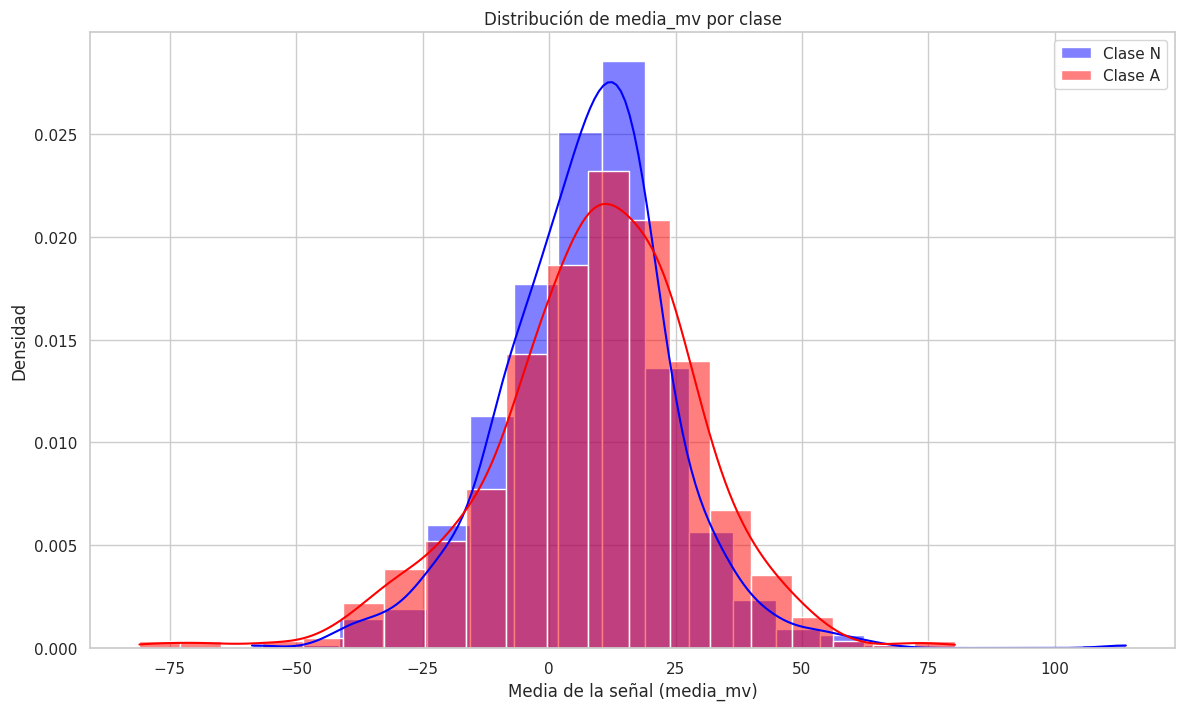

In [183]:
#mostrar estadísticas descriptivas y con su curva normal con histogramas con transparencia y descripción y separados por colores para cada clase, rojo para A y azul N, pero en el mismo histograma
import matplotlib.pyplot as plt
import seaborn as sns
# Configuración de estilo
sns.set(style="whitegrid")
# Crear figura y ejes
plt.figure(figsize=(14, 8))
# Histograma de 'media_mv' para clase N
sns.histplot(df_selected[df_selected['clase'].str.startswith('N')]['media_mv'],
             color='blue', label='Clase N', kde=True, stat='density', alpha=0.5, bins=20)
# Histograma de 'media_mv' para clase A
sns.histplot(df_selected[df_selected['clase'].str.startswith('A')]['media_mv'],
             color='red', label='Clase A', kde=True, stat='density', alpha=0.5, bins=20)
# Añadir título y etiquetas
plt.title('Distribución de media_mv por clase')
plt.xlabel('Media de la señal (media_mv)')
plt.ylabel('Densidad')
# Añadir leyenda
plt.legend()
# Mostrar gráfico
plt.show()


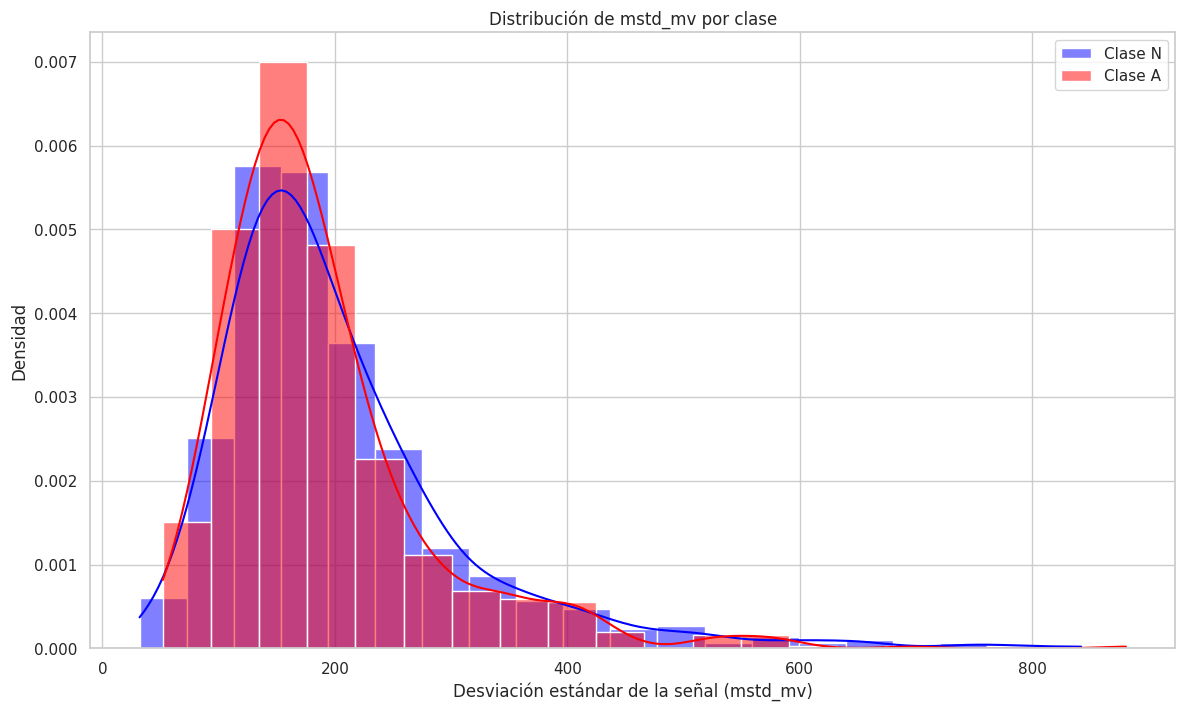

In [184]:
# Histograma de 'mstd_mv' para clase N
plt.figure(figsize=(14, 8))
sns.histplot(df_selected[df_selected['clase'].str.startswith('N')]['mstd_mv'],
             color='blue', label='Clase N', kde=True, stat='density', alpha=0.5, bins=20)
# Histograma de 'mstd_mv' para clase A
sns.histplot(df_selected[df_selected['clase'].str.startswith('A')]['mstd_mv'],
             color='red', label='Clase A', kde=True, stat='density', alpha=0.5, bins=20)
# Añadir título y etiquetas
plt.title('Distribución de mstd_mv por clase')
plt.xlabel('Desviación estándar de la señal (mstd_mv)')
plt.ylabel('Densidad')
# Añadir leyenda
plt.legend()
# Mostrar gráfico
plt.show()

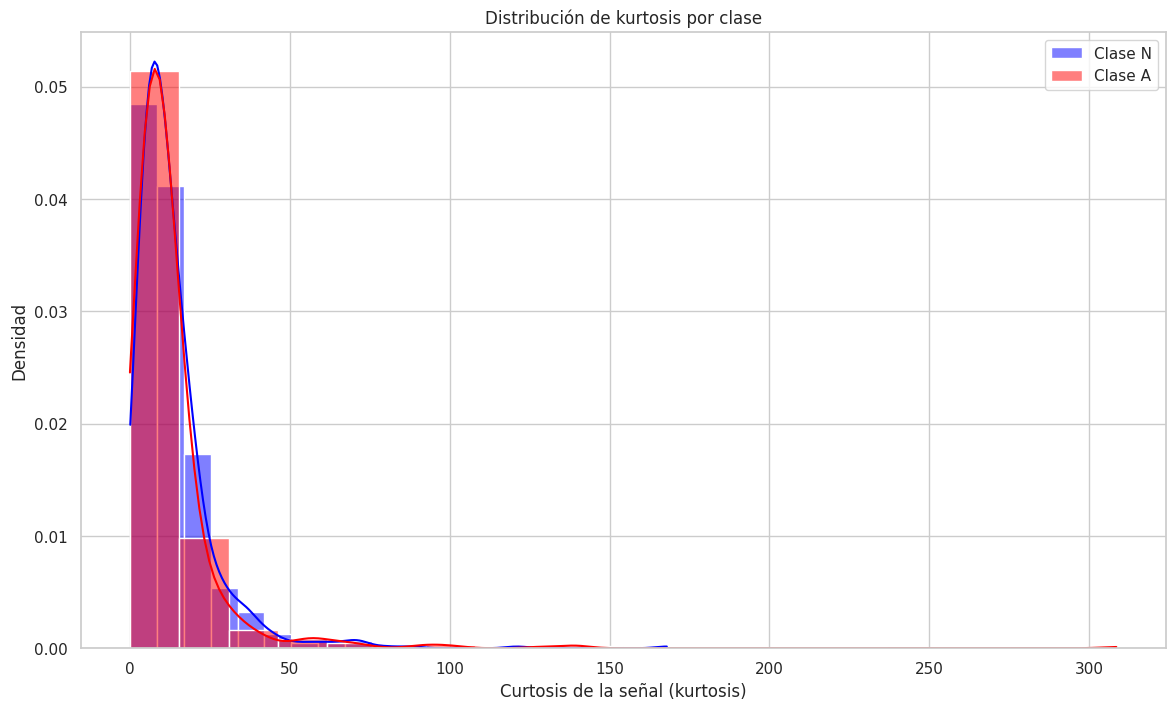

In [185]:
# Histograma de 'kurtosis' para clase N
plt.figure(figsize=(14, 8))
sns.histplot(df_selected[df_selected['clase'].str.startswith('N')]['kurtosis'],
             color='blue', label='Clase N', kde=True, stat='density', alpha=0.5, bins=20)
# Histograma de 'kurtosis' para clase A
sns.histplot(df_selected[df_selected['clase'].str.startswith('A')]['kurtosis'],
             color='red', label='Clase A', kde=True, stat='density', alpha=0.5, bins=20)
# Añadir título y etiquetas
plt.title('Distribución de kurtosis por clase')
plt.xlabel('Curtosis de la señal (kurtosis)')
plt.ylabel('Densidad')
# Añadir leyenda
plt.legend()
# Mostrar gráfico
plt.show()

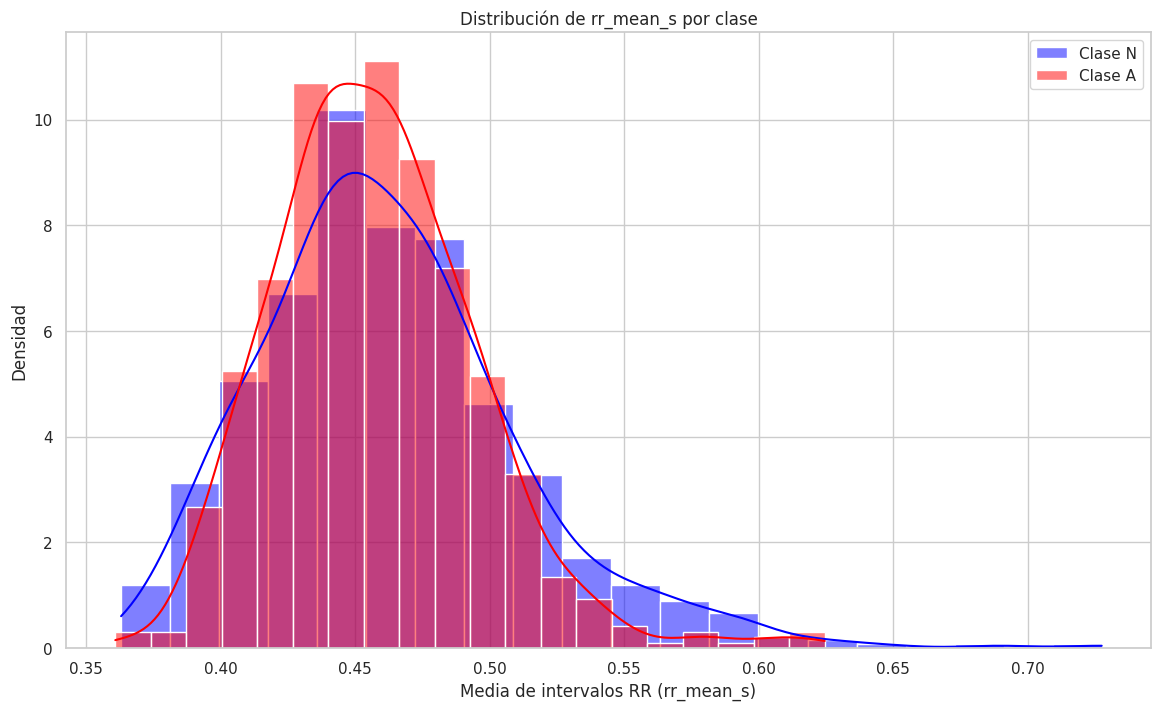

In [186]:
# Histograma de 'rr_mean_s' para clase N
plt.figure(figsize=(14, 8))
sns.histplot(df_selected[df_selected['clase'].str.startswith('N')]['rr_mean_s'],
             color='blue', label='Clase N', kde=True, stat='density', alpha=0.5, bins=20)
# Histograma de 'rr_mean_s' para clase A
sns.histplot(df_selected[df_selected['clase'].str.startswith('A')]['rr_mean_s'],
             color='red', label='Clase A', kde=True, stat='density', alpha=0.5, bins=20)
# Añadir título y etiquetas
plt.title('Distribución de rr_mean_s por clase')
plt.xlabel('Media de intervalos RR (rr_mean_s)')
plt.ylabel('Densidad')
# Añadir leyenda
plt.legend()
# Mostrar gráfico
plt.show()

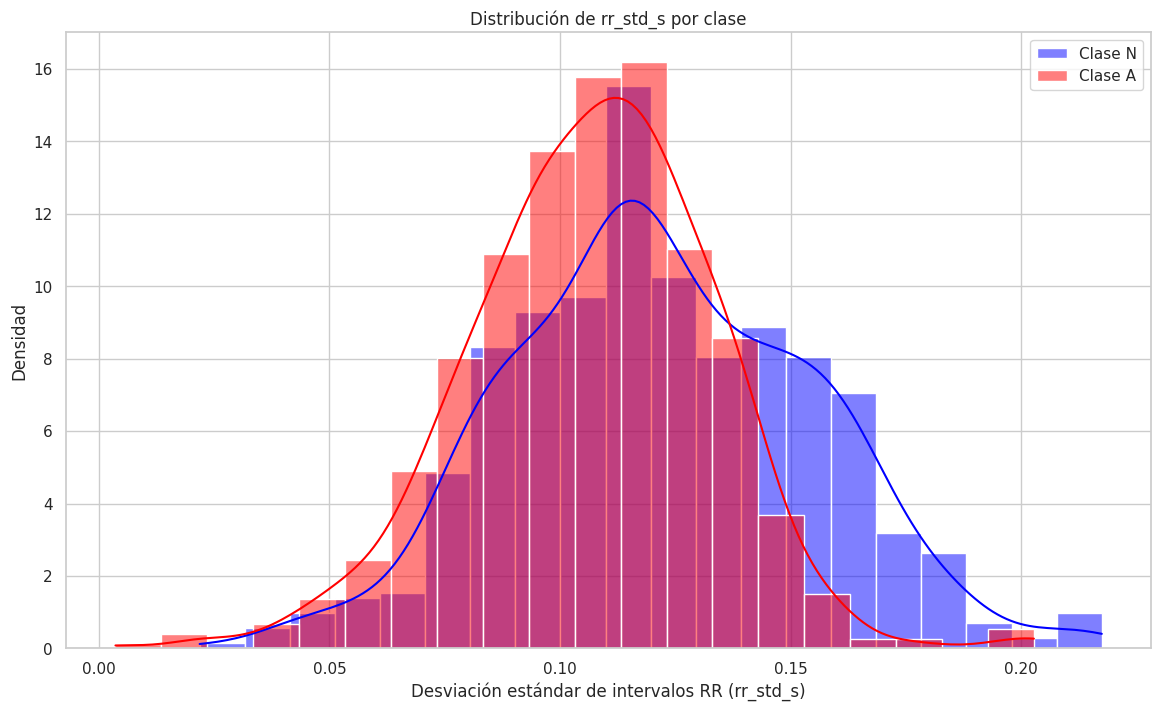

In [187]:
# Histograma de 'rr_std_s' para clase N
plt.figure(figsize=(14, 8))
sns.histplot(df_selected[df_selected['clase'].str.startswith('N')]['rr_std_s'],
             color='blue', label='Clase N', kde=True, stat='density', alpha=0.5, bins=20)
# Histograma de 'rr_std_s' para clase A
sns.histplot(df_selected[df_selected['clase'].str.startswith('A')]['rr_std_s'],
             color='red', label='Clase A', kde=True, stat='density', alpha=0.5, bins=20)
# Añadir título y etiquetas
plt.title('Distribución de rr_std_s por clase')
plt.xlabel('Desviación estándar de intervalos RR (rr_std_s)')
plt.ylabel('Densidad')
# Añadir leyenda
plt.legend()
# Mostrar gráfico
plt.show()

¿Qué variables parecen diferenciar más entre clases?

Las variables que parecen diferenciar más entre las clases N y A, basándonos en los histogramas y la distribución de los datos, son:
1. **Media de la señal (media_mv)**: La clase N muestra una distribución más concentrada y menos dispersa en comparación con la clase A, que tiene una mayor variabilidad.
2. **Desviación estándar de la señal (mstd_mv)**: Similar a la media, la clase N tiene una desviación estándar más baja, lo que indica menos variabilidad en la señal.
3. **Asimetría (skewness)**: La clase N tiende a tener una asimetría más cercana a cero, mientras que la clase A muestra una mayor asimetría, lo que indica que la distribución de los datos es más sesgada.
4. **Curtosis (kurtosis)**: La clase N tiene una curtosis más baja, lo que sugiere que la distribución es más plana en comparación con la clase A, que muestra picos más altos.
5. **Media de intervalos RR (rr_mean_s)**: La clase N tiene una media de intervalos RR más baja, lo que indica un ritmo cardíaco más regular en comparación con la clase A.
6. **Desviación estándar de intervalos RR (rr_std_s)**: La clase N muestra una desviación estándar más baja, lo que sugiere menos variabilidad en los intervalos RR en comparación con la clase A.


¿Qué aspectos del dataset llaman la atención?

Algunos aspectos que pueden llamar la atención del dataset son:
1. Desbalance de clases: Si hay una diferencia significativa en el número de registros entre las clases 'N' y 'A', esto puede afectar el rendimiento del modelo.
2. Distribución de características: Las distribuciones de las características como 'media_mv', 'mstd_mv', 'skewness', 'kurtosis', 'rr_mean_s' y 'rr_std_s' pueden mostrar diferencias significativas entre las clases, lo que puede ser útil para la clasificación.
4. Duración de las secuencias: La duración de las secuencias puede variar entre registros, lo que podría influir en el análisis temporal.
5. Comparación de estadísticas descriptivas: Las estadísticas descriptivas como la media, desviación estándar, asimetría y curtosis pueden proporcionar información sobre la naturaleza de las señales en cada clase.
6. Comportamiento de los intervalos RR: La media y desviación estándar de los intervalos RR pueden proporcionar información sobre la variabilidad de la frecuencia cardíaca en cada clase.
7. Visualización de distribuciones: Los histogramas y gráficos de densidad pueden ayudar a visualizar las diferencias en la distribución de las características entre las clases.
8. Comparación de clases: La comparación entre las clases 'N' y 'A' en términos de características puede revelar diferencias significativas que pueden ser útiles para la clasificación.
9. Análisis de la variabilidad de la frecuencia cardíaca: La variabilidad de la frecuencia cardíaca puede ser un indicador importante de la salud cardiovascular y puede variar entre las clases.

Entrenar Modelo

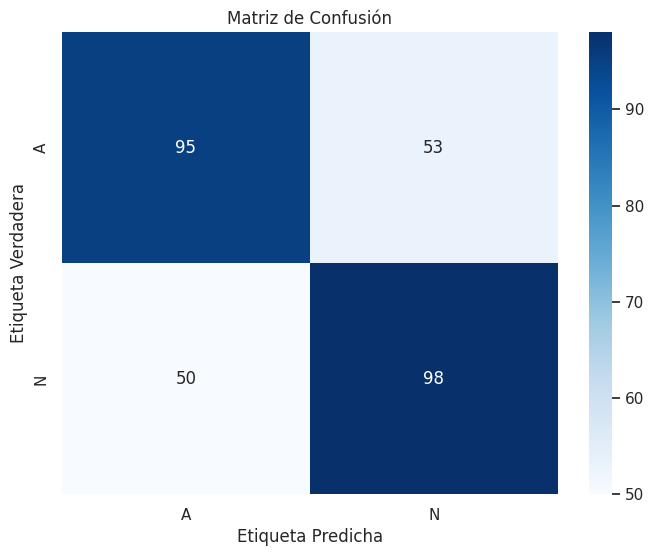


Reporte de Clasificación:
              precision    recall  f1-score   support

           A       0.66      0.64      0.65       148
           N       0.65      0.66      0.66       148

    accuracy                           0.65       296
   macro avg       0.65      0.65      0.65       296
weighted avg       0.65      0.65      0.65       296



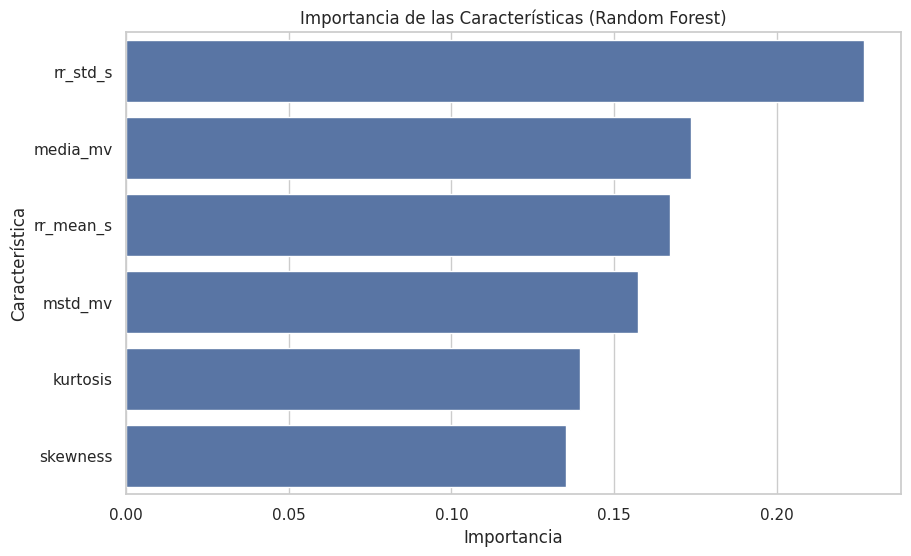

In [188]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Preparar los datos para el modelo
# Seleccionar características y etiquetas
features = ['media_mv', 'mstd_mv', 'skewness', 'kurtosis', 'rr_mean_s', 'rr_std_s']
X = df_selected[features]
y = df_selected['clase']

# Convertir etiquetas a formato numérico si es necesario (RandomForest puede manejar strings, pero es buena práctica)
# Aquí asumimos que 'N' y 'A' son las únicas clases de interés para el modelo, o que queremos clasificar todo.
# Si solo nos interesan N y A, filtramos el dataframe antes de entrenar.
X_filtered = df_selected[features]
y_filtered = df_selected['clase']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.20, random_state=42, stratify=y_filtered) # stratify ayuda con desbalance de clases

# Entrenar el modelo de Random Forest
model = RandomForestClassifier(n_estimators=250)
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar el modelo con la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['A', 'N'], yticklabels=['A', 'N'])
plt.title('Matriz de Confusión')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.show()

# Mostrar reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))
# Obtener la importancia de las características del modelo entrenado
feature_importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)


# Visualizar la importancia de las características
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title('Importancia de las Características (Random Forest)')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.show()


Visualizar	errores	y	proponer	ideas	de	mejora

Creo que a modo personal, lo mejor qu es epodría hacer para aumentar el accuracy, es:
1.- Aumentar el tamaño del dataset
2.- Aumentar el tamaño de bosques para el random forest